# <center>**Neural Networks and Deep Learning**</center><br>
# <center>**Coursework 3**</center><br> 
### **Name : Kweku E. Acquaye**

This report uses modern data science methods to attempt to build, train, evaluate, and plot a neural network (NN) model using first principles rather than using high level API packages such as scikit-learn or keras. It trains on the Fashion-MNIST data (Xiao _et al_, 2017), a 10-class dataset of 60,000 greyscale clothing item images, and evalutates on a further 10,000 item images.<br>  

This work constitutes Coursework 2 in fulfilment of the requirements of NN and DL Course.

**Declaration:** Some of the code used in this assignment has been adapted and customized from www.docs.python.org/, www.pandas.pydata.org/docs, www.pytorch.org/tutorials/, www.matplotlib.org/stable/, www.stackoverflow.com/questions/, www.geeksforgeeks.org/fundamentals-of-algorithms/, www.machinelearningmind.com/, www.kaggle.com/, www.scikit-learn.org, www.numpy.org/doc/stable/user/, www.github.com/, and Course NN & DL Lab, Tutorial, and Lecture Notes.<br> 

### **Section 1: Preparation**
Accessing Google Drive for utilities file:<br> 
_**Note:**_ This notebook requires _my_utils_ custom utilities file (Zhang et al., 2021) loaded in same directory to execute.

In [ ]:
# Mounting google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/fmn')

Mounted at /content/gdrive


Loading packages and dependencies:

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import my_utils as mu
import torch
from torch import nn
from IPython import display

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
print(torch.__version__)

1.10.0+cu111


The dataset is now loaded as follows:

In [ ]:
# Loading dataset
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



### **Section 2: Building the Model**
The following few steps defines the neural network architecture and pipeline:

In [ ]:
class Net(torch.nn.Module):
    # Defining NN model
    def __init__(self, num_inputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, num_hidden6, num_hidden7, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs    
        self.num_hidden1 = num_hidden1    
        self.num_hidden2 = num_hidden2    
        self.num_hidden3 = num_hidden3    
        self.num_hidden4 = num_hidden4    
        self.num_hidden5 = num_hidden5    
        self.num_hidden6 = num_hidden6    
        self.num_hidden7 = num_hidden7    
        self.num_outputs = num_outputs
        self.Linear1 = nn.Linear(num_inputs, num_hidden1)       # stem
        self.Linear2 = nn.Linear(num_hidden1, num_hidden2)      # block 1
        self.Linear3 = nn.Linear(num_hidden2, num_hidden3)      # block 1
        self.Linear4 = nn.Linear(num_hidden3, num_hidden4)      # block 2
        self.Linear5 = nn.Linear(num_hidden4, num_hidden5)      # block 2
        self.Linear6 = nn.Linear(num_hidden5, num_hidden6)      # block 3
        self.Linear7 = nn.Linear(num_hidden6, num_hidden7)      # block 3
        self.Linear8 = nn.Linear(num_hidden7, num_outputs)      # classifier
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # defining NN structure
        x = x.view(-1, self.num_inputs)
        out = self.Linear1(x)
        out = self.relu(out)
        out = self.Linear2(out)
        out = self.relu(out)
        out = self.Linear3(out)
        out = self.relu(out)
        out = self.Linear4(out)
        out = self.relu(out)
        out = self.Linear5(out)
        out = self.relu(out)
        out = self.Linear6(out)
        out = self.relu(out)
        out = self.Linear7(out)
        out = self.Linear8(out)
        return out

In [ ]:
# Instantiating and initialisating model 
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)
        torch.nn.init.zeros_(m.bias)

The following step builds the model:

In [ ]:
# Creating model
num_inputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, num_hidden6, num_hidden7, num_outputs = 784, 256, 512, 512, 256, 128, 64, 10, 10

# Initialising model with init_weights function
net = Net(num_inputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, num_hidden6, num_hidden7, num_outputs)

The next step defines the loss function, sets weight decay and learning rate hyperparameters, and defines the activation function. 

In [ ]:
# Instantiating loss function
loss = nn.CrossEntropyLoss()

# Setting model hyperparameters
wd, lr = 0.0001, 0.001

# Instantiating non-linear activation function
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

After much experimentation, the above hyperparameters were found to be optimum for the network.

The following few steps creates multiple functions to<br> 
1. train the model 
2. accumulate analysed data 
3. output progress in a plotted illustration 
4. evaluate model performance in terms of accuracy


In [ ]:
# Evaluation function
def accuracy(y_hat, y): 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # index of max score = predicted class          
    cmp = (y_hat.type(y.dtype) == y)  # `==` is sensitive to data types
    return float(torch.sum(cmp)) # number of correct predictions

In [ ]:
class Accumulator:  
    # Accumulating sums over `n` variables
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def evaluate_accuracy(net, data_iter): 
    # Compute the accuracy for a model on a dataset
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_epoch_ch3(net, train_iter, loss, optimizer):  
    # Training function for one epoch
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
class Animator:
    # Plotting data in animation
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5.5, 3.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
# Defining model training function
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics 

### **Section 3: Running the Model**
In the next step, the built NN model and all the created auxiliary functions are deployed to implement training, and then testing, of the model on the dataset:<br> 

_**Note:**_ Takes a while to execute (approximately 30 minutes), please remain patient. 

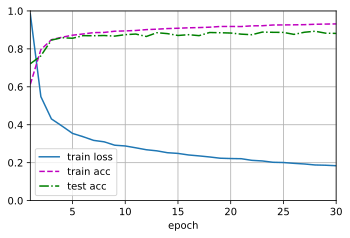

In [ ]:
# Implementing model training and testing
num_epochs = 30
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

The following 2 steps implement evaluation of model performance:

In [ ]:
# Outputting training accuracy
training_acc = evaluate_accuracy(net, train_iter)
print("Model training accuracy is", training_acc)

Model training accuracy is 0.9298333333333333


In [ ]:
# Outputting test accuracy
testing_acc = evaluate_accuracy(net, test_iter)
print("Model testing accuracy is", testing_acc)

Model testing accuracy is 0.8816


### **Section 4: Conclusions**

A neural network model was successfully built using first principles rather than using high level API packages such as scikit-learn or keras. The obtained mean training accuracy of 93.4% (with standard deviation 0.01 over 12 runs), and mean testing accuracy of 89.5% (with standard deviation 0.01 over 12 runs) indicates no evidence of overfitting, and can be described in terms of performance as excellent for a simple MLP network using no convolutions.

### <center>**References**<center/>

1. Xiao, H., Rasul, K. and Vollgraf, R. (2017), _Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms_, arXiv preprint arXiv:1708.07747, [online]: 
https://doi.org/10.48550/arXiv.1708.07747

2. Xiao _et al_ on GitHub [online]: https://github.com/zalandoresearch/fashion-mnist

3. Xiao _et al_ on Kaggle [online]: https://www.kaggle.com/datasets/zalando-research/fashionmnist

4. Zhang, A., Lipton, Z.C., Li, M. and Smola, A.J., 2021. Dive into deep learning. arXiv preprint arXiv:2106.11342. [online]: http://d2l.ai/